In [33]:
%pip install 'qiskit[optimization]'
%pip install networkx

from IPython.display import clear_output
clear_output()

In [61]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

## MaxCut 2x2 Ising Model

In [62]:
# Generating the system

N = 2
G1 = nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G1.nodes() )
labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )

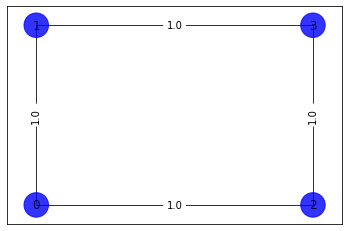

In [63]:
# Transform to weighted graph:
n = N**2
V = np.arange(0, N, 1)

E =[]

tuples = []
other_tup = []
point_edge_map = []
other_map = []
relations = []

for edge in G1.edges:
    point1 = edge[0]
    strpoint1 = str(point1[0]) + str(point1[1])
    point2 = edge[1]
    strpoint2 = str(point2[0]) + str(point2[1])
    if not strpoint1 in point_edge_map:
        point_edge_map.append(strpoint1)
        tuples.append(edge[0])
    if not strpoint2 in other_map:
        other_map.append(strpoint2)
        other_tup.append(edge[1])
    relations.append((strpoint1, strpoint2))

tuples.append(other_tup[len(other_tup) - 1])
point_edge_map.append(other_map[len(other_map) - 1])

dic = {}
for i in range(len(point_edge_map)):
    dic[i] = point_edge_map[i]
    
point_edge_map = np.array(point_edge_map)
relations = np.array(relations)

for relation in relations:
    ver1 = relation[0]
    ver2 = relation[1]
    point1 = np.where(point_edge_map == ver1)[0][0]
    point2 = np.where(point_edge_map == ver2)[0][0]
    edge = (point1, point2, 1.0)
    E.append(edge)
    
G = nx.Graph()

G.add_nodes_from(V)

G.add_weighted_edges_from(E)

colors = ["b" for node in G.nodes()]
pos = dict()
for i in range(n):
    pos[i] = tuples[i]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

# Representing Graphs in terms of Adjacency Matrix
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
For a non directed graph with n verticies, on can represent it in term of an adjacency matrix:
$$\sum_{i=1}^n \sum_{j=1}^n m_{ij} \ket{i}\bra{j}$$
Where $m_{ij} = $ weight of edge ij and 0 if there is no edge between the two vertices

In [64]:
# Matrix Representation of Graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

print(w)

[[0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]


## Classical (Brute Force) Approach

In [65]:
%%time

best_cost_brute = 0
config = []
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    config.append((x, ))
    print("case = " + str(x) + " cost = " + str(cost))

# print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 2.0
case = [0, 0, 1, 0] cost = 2.0
case = [1, 0, 1, 0] cost = 2.0
case = [0, 1, 1, 0] cost = 4.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 4.0
case = [0, 1, 0, 1] cost = 2.0
case = [1, 1, 0, 1] cost = 2.0
case = [0, 0, 1, 1] cost = 2.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 2.0
case = [1, 1, 1, 1] cost = 0.0
CPU times: user 1.94 ms, sys: 1.15 ms, total: 3.09 ms
Wall time: 2.14 ms


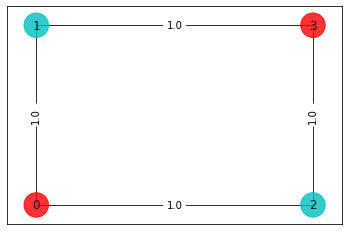

In [66]:
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.

In [67]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_3 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 2*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [68]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.0
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * ZIZI
+ 0.5 * ZZII


In [69]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

energy: -2.0
max-cut objective: -4.0
solution: [0 1 1 0]
solution objective: 4.0


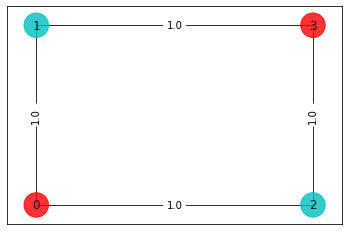

In [70]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [71]:
from qiskit.tools.monitor import job_monitor

IBMQ.save_account("7cb4f79065a907acf99992e460fff346bbd8434797d53f2be93eed106bfbcb23e32c91e9809b269b8726306c3d357b1ce0d037b0e3efb749898da522a89c0932")
provider = IBMQ.load_account()

available_cloud_backends = provider.backends()
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)

configrc.store_credentials:WARNING:2022-09-23 16:01:32,200: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-09-23 16:01:32,382: Credentials are already in use. The existing account in the session will be replaced.



Here is the list of cloud backends that are available to you:
ibmq_qasm_simulator
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila
ibm_nairobi
ibm_oslo


In [72]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.9941406250000002
time: 2.3139829635620117
max-cut objective: -3.994140625
solution: [0 1 1 0]
solution objective: 4.0


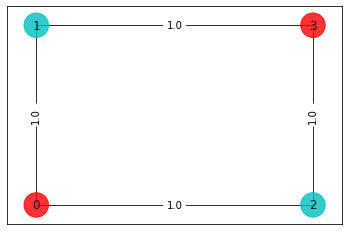

In [73]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0
status: SUCCESS


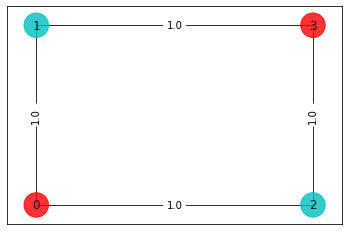

In [74]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## MaxCut 3x3 Ising Model

In [75]:
# Generating the system

N = 3
G1 = nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G1.nodes() )
labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )

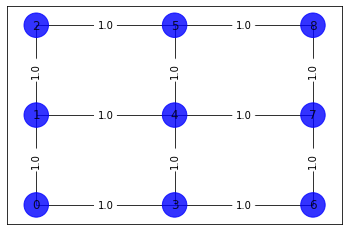

In [76]:
# Transform to weighted graph:
n = N**2
V = np.arange(0, N, 1)

E =[]

tuples = []
other_tup = []
point_edge_map = []
other_map = []
relations = []

for edge in G1.edges:
    point1 = edge[0]
    strpoint1 = str(point1[0]) + str(point1[1])
    point2 = edge[1]
    strpoint2 = str(point2[0]) + str(point2[1])
    if not strpoint1 in point_edge_map:
        point_edge_map.append(strpoint1)
        tuples.append(edge[0])
    if not strpoint2 in other_map:
        other_map.append(strpoint2)
        other_tup.append(edge[1])
    relations.append((strpoint1, strpoint2))

tuples.append(other_tup[len(other_tup) - 1])
point_edge_map.append(other_map[len(other_map) - 1])

dic = {}
for i in range(len(point_edge_map)):
    dic[i] = point_edge_map[i]
    
point_edge_map = np.array(point_edge_map)
relations = np.array(relations)

for relation in relations:
    ver1 = relation[0]
    ver2 = relation[1]
    point1 = np.where(point_edge_map == ver1)[0][0]
    point2 = np.where(point_edge_map == ver2)[0][0]
    edge = (point1, point2, 1.0)
    E.append(edge)
    
G = nx.Graph()

G.add_nodes_from(V)

G.add_weighted_edges_from(E)

colors = ["b" for node in G.nodes()]
pos = dict()
for i in range(n):
    pos[i] = tuples[i]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

# Representing Graphs in terms of Adjacency Matrix
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
For a non directed graph with n verticies, on can represent it in term of an adjacency matrix:
$$\sum_{i=1}^n \sum_{j=1}^n m_{ij} \ket{i}\bra{j}$$
Where $m_{ij} = $ weight of edge ij and 0 if there is no edge between the two vertices

In [77]:
# Matrix Representation of Graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        print("i: ", i)
        print("j: ", j)
        if temp != 0:
            w[i, j] = temp["weight"]

print(w)

i:  0
j:  0
i:  0
j:  1
i:  0
j:  2
i:  0
j:  3
i:  0
j:  4
i:  0
j:  5
i:  0
j:  6
i:  0
j:  7
i:  0
j:  8
i:  1
j:  0
i:  1
j:  1
i:  1
j:  2
i:  1
j:  3
i:  1
j:  4
i:  1
j:  5
i:  1
j:  6
i:  1
j:  7
i:  1
j:  8
i:  2
j:  0
i:  2
j:  1
i:  2
j:  2
i:  2
j:  3
i:  2
j:  4
i:  2
j:  5
i:  2
j:  6
i:  2
j:  7
i:  2
j:  8
i:  3
j:  0
i:  3
j:  1
i:  3
j:  2
i:  3
j:  3
i:  3
j:  4
i:  3
j:  5
i:  3
j:  6
i:  3
j:  7
i:  3
j:  8
i:  4
j:  0
i:  4
j:  1
i:  4
j:  2
i:  4
j:  3
i:  4
j:  4
i:  4
j:  5
i:  4
j:  6
i:  4
j:  7
i:  4
j:  8
i:  5
j:  0
i:  5
j:  1
i:  5
j:  2
i:  5
j:  3
i:  5
j:  4
i:  5
j:  5
i:  5
j:  6
i:  5
j:  7
i:  5
j:  8
i:  6
j:  0
i:  6
j:  1
i:  6
j:  2
i:  6
j:  3
i:  6
j:  4
i:  6
j:  5
i:  6
j:  6
i:  6
j:  7
i:  6
j:  8
i:  7
j:  0
i:  7
j:  1
i:  7
j:  2
i:  7
j:  3
i:  7
j:  4
i:  7
j:  5
i:  7
j:  6
i:  7
j:  7
i:  7
j:  8
i:  8
j:  0
i:  8
j:  1
i:  8
j:  2
i:  8
j:  3
i:  8
j:  4
i:  8
j:  5
i:  8
j:  6
i:  8
j:  7
i:  8
j:  8
[[0. 1. 0. 1. 0. 0. 0. 0. 0.

## Classical (Brute Force) Approach

In [78]:
%%time

best_cost_brute = 0
config = []
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    config.append((x, ))
    print("case = " + str(x) + " cost = " + str(cost))

print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0] cost = 5.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0] cost = 4.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 0, 1, 0, 0, 0, 0] cost = 5.0
case = [1, 1, 0, 0, 1, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 1, 0, 1, 0, 0, 0, 0] cost = 6.0
case = [1, 0, 1, 0, 1, 0, 0, 0, 0]

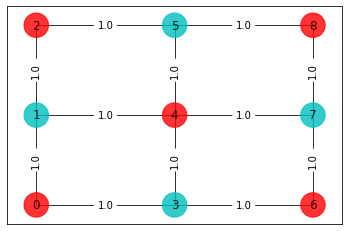

In [79]:
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.

In [80]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_4 - 2*x_2*x_5 - 2*x_3*x_4
  - 2*x_3*x_6 - 2*x_4*x_5 - 2*x_4*x_7 - 2*x_5*x_8 - 2*x_6*x_7 - 2*x_7*x_8
  + 2*x_0 + 3*x_1 + 2*x_2 + 3*x_3 + 4*x_4 + 3*x_5 + 2*x_6 + 3*x_7 + 2*x_8

Subject to
  No constraints

  Binary variables (9)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8



In [81]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -6.0
Ising Hamiltonian:
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIZI
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIZII
+ 0.5 * IIIZZIIII
+ 0.5 * IIZIIZIII
+ 0.5 * IZIIZIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZZIIIIIII


In [82]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 12.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

energy: -6.0
max-cut objective: -12.0
solution: [0 1 0 1 0 1 0 1 0]
solution objective: 12.0


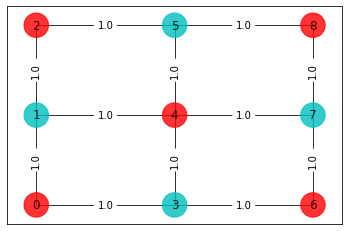

In [83]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [84]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [85]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -5.238281249999999
time: 15.38385820388794
max-cut objective: -11.23828125
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0


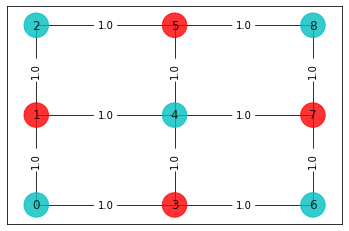

In [89]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 12.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0
status: SUCCESS


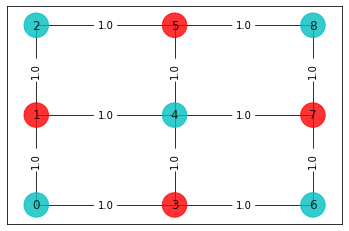

In [87]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)